<a href="https://colab.research.google.com/github/2022-Business-Analytics/crop_disease_risk/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import json
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import json
import time
from tqdm import tqdm
from IPython.display import display

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_json = pd.DataFrame() # initialize Empty DataFrame

In [ ]:
def read_json_files():
    global train_json
    for i in range(10027,67680): # 파일명 10027부터 67678까지
        for json_file in glob('/Users/byeonsang-u/Downloads/data/train/'+str(i)+'/*.json'): # 파일 경로 지정
            with open(json_file, 'r') as f:
                json_file = json.load(f)
            json_file_re = { # 변수명 한글로 변경
              '주목객체': json_file['annotations']['bbox'],
              '병해부위': json_file['annotations']['part'],
              '촬영부위': json_file['annotations']['area'], 
              '작물': json_file['annotations']['crop'],
              '질병명': json_file['annotations']['disease'],
              '생육단계': json_file['annotations']['grow'],
              '피해정도': json_file['annotations']['risk'],
              '이미지id': json_file['description']['image'],
              '촬영날짜': json_file['description']['date'],
              '촬영시간': json_file['description']['time'],
              'height': json_file['description']['height'],
              'width': json_file['description']['width'],
              '촬영지역': json_file['description']['region'],
              '데이터종류': json_file['description']['task']
            }
            if i == 0: # 빈 데이터프레임에 변수명 바뀐 데이터 저장
                train_json = pd.json_normalize(json_file_re)
            else:
                train_json = train_json.append(pd.json_normalize(json_file_re))
    train_json = train_json.reset_index(drop=True)

In [ ]:
read_json_files()

In [ ]:
# 변수값이 의미하는 이름으로 mapping 하기 위한 dictionary

# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }

# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }

# disease
disease_dict = {'0' : '정상',
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [ ]:
# "작물_질병명_피해정도"로 새로운 label_code 추가
train_json['label_code'] =  train_json['작물'].astype(str) + '_'  + train_json['질병명'] + '_' + train_json['피해정도'].astype(str)

# mapping
train_json['작물'] = train_json['작물'].map(crop_dict) + '(' + train_json['작물'].astype(str) + ')'
train_json['질병명'] = train_json['질병명'].map(disease_dict) + '(' + train_json['질병명'].astype(str) + ')'
train_json['피해정도'] = train_json['피해정도'].map(risk_dict) + '(' + train_json['피해정도'].astype(str) + ')'
train_json['데이터종류'] = train_json['데이터종류'].map(task_dict) + '(' + train_json['데이터종류'].astype(str) + ')'
train_json['촬영부위'] = train_json['촬영부위'].map(area_dict) + '(' + train_json['촬영부위'].astype(str) + ')'
train_json['생육단계'] = train_json['생육단계'].map(grow_dict) + '(' + train_json['생육단계'].astype(str) + ')'

# mapping한 후에 "작물_질병명_피해정도"로 새로운 label_name 추가
train_json['label_name'] =  train_json['작물'].astype(str) + '_'  + train_json['질병명'] + '_' + train_json['피해정도'].astype(str)

In [ ]:
display(train_json.shape, train_json.head())

(5767, 16)

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
0,"[{'x': 89.14301990327381, 'h': 237.86294022817...","[{'x': 125.57248263888889, 'h': 78.85906498015...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),10027.jpg,20211126,0935,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)
1,"[{'x': 166.36469184027777, 'h': 315.9944816468...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),10037.jpg,20210914,0925,512,384,0,정상(0),3_00_0,NaN
2,"[{'x': 55.17857142857143, 'h': 271.60714285714...",[],열매(1),파프리카(3),NaN,착화/과실기(13),정상(0),10043.jpg,20210624,1332,512,384,0,정상(0),3_00_0,NaN
3,"[{'x': 128.79953342013889, 'h': 263.3427579365...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),10045.jpg,20210915,1616,512,384,0,정상(0),3_00_0,NaN
4,"[{'x': 42.85714453125, 'h': 283.9285625, 'y': ...",[],열매(1),파프리카(3),NaN,착화/과실기(13),정상(0),10063.jpg,20210624,1430,512,384,0,정상(0),3_00_0,NaN


In [ ]:
import platform
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings("ignore")

if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

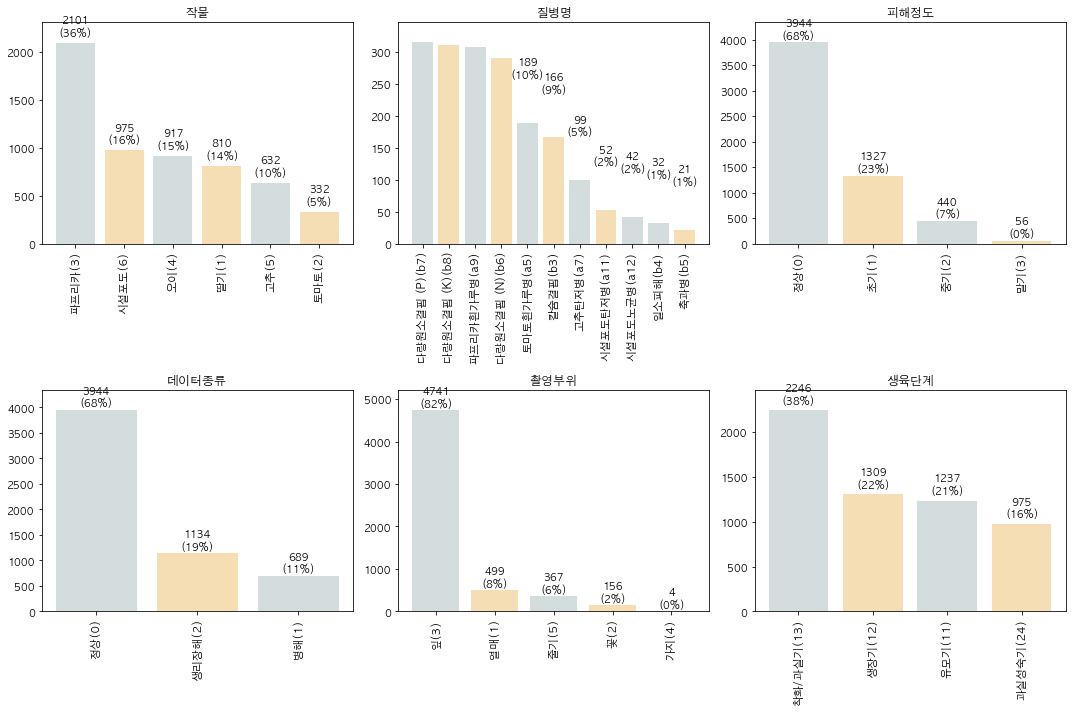

In [ ]:
f, axs = plt.subplots(2,3,figsize=(15,10))
axs = axs.flatten()
for i, col in enumerate(['작물', '질병명', '피해정도', '데이터종류', '촬영부위', '생육단계']):
    object_cnt = train_json[col].value_counts().sort_values(ascending=False)
    axs[i].bar(object_cnt.index, object_cnt.values, color=['#d4dddd' if i%2==0 else '#F5DEB3' for i in range(9)])
    for x,y,z in zip(object_cnt.index, object_cnt.values,object_cnt.values/object_cnt.sum()*100):                                       # <--
        axs[i].annotate('%d\n(%d%%)' %(int(y),z), xy=(x,y+70), textcoords='data', ha = 'center') 
    axs[i].axis(ymin=0,ymax=int(max(object_cnt)*1.1))
    axs[i].set_xticklabels(object_cnt.index, rotation = 90,fontsize = 11)
    axs[i].set_title(col)
f.tight_layout()
plt.show()